#### A quick demonstration of bias-hardened lensing/patchy tau/point source reconstruction in fullsky
#### - this code shows how to compute the estiamtors, and output their power spectra

In [1]:
import numpy as np, basic, curvedsky, plottools as pl, cmb
from matplotlib.pyplot import *

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 50.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)

#### load unlensed and lensed Cls

In [3]:
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

#### calculate normalizations

In [4]:
Altt = curvedsky.norm_quad.qtt('amp',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]
Alpp = curvedsky.norm_quad.qtt('lens',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]
Alss = curvedsky.norm_quad.qtt('src',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]

In [5]:
Rlpt = curvedsky.norm_quad.xtt('lensamp',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
Rlps = curvedsky.norm_quad.xtt('lenssrc',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
Rlts = curvedsky.norm_quad.xtt('ampsrc',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])

In [6]:
DetR = 1 - Alpp*Alss*Rlps**2 - Alpp*Altt*Rlpt**2 - Altt*Alss*Rlts**2 + 2.*Alpp*Altt*Alss*Rlpt*Rlps*Rlts

In [7]:
Bltt = (1.-Alpp*Alss*Rlps**2)/DetR * Altt
Bltp = (Rlts*Alss*Rlps-Rlpt)/DetR * Altt * Alpp
Blts = (Rlpt*Alpp*Rlps-Rlts)/DetR * Altt * Alss

In [8]:
# simple diagonal c-inverse
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [9]:
# generate CMB alms 
# - gaussian alms are generated, and the reconstructed cls are equal to the normalization
Talm0 = curvedsky.utils.gauss1alm(lmax,lcl[0,:])
Talm1 = curvedsky.utils.gauss1alm(lmax,lcl[0,:])

In [10]:
# add noise
Talm0 += curvedsky.utils.gauss1alm(lmax,nl[0,:])
Talm1 += curvedsky.utils.gauss1alm(lmax,nl[0,:])

In [11]:
# diagonal filtering
Talm0 *= Fl[0,:,:]
Talm1 *= Fl[0,:,:]

In [12]:
# compute unnormalized estiamtors
almt01 = curvedsky.rec_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm0,Talm1,nside_t=1024)
almt10 = curvedsky.rec_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm1,Talm0,nside_t=1024)

In [13]:
almp01, __ = curvedsky.rec_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm0,Talm1,nside_t=1024)
almp10, __ = curvedsky.rec_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm1,Talm0,nside_t=1024)

In [14]:
alms01 = curvedsky.rec_src.qtt(lmax,rlmin,rlmax,Talm0,Talm1,nside_t=1024)
alms10 = curvedsky.rec_src.qtt(lmax,rlmin,rlmax,Talm1,Talm0,nside_t=1024)

In [15]:
# bhe
blmt01 = Bltt[:,None]*almt01 + Bltp[:,None]*almp01 + Blts[:,None]*alms01
blmt10 = Bltt[:,None]*almt10 + Bltp[:,None]*almp10 + Blts[:,None]*alms10

In [16]:
# compute cross spectra
cl = curvedsky.utils.alm2cl(lmax,blmt01+blmt10)

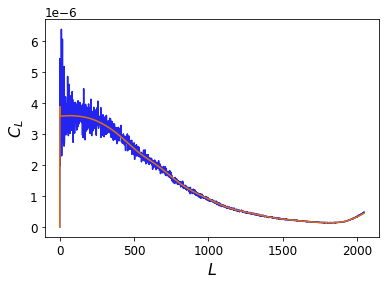

In [17]:
pl.plot_1dstyle()
plot(cl/2.)
plot(Bltt)